# Setup

## 1.1 Installing Dependencies

In [1]:
!pip3 install tensorflow opencv-python matplotlib

In [2]:
# tensorflow gpu installation failure

!pip3 install tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


## 1.2 Importing Dependencies

In [2]:
#Importing standard dependenicies

import numpy as np

#importing open cv
import cv2

#The OS module provides functions for interacting with the OS
import os

# For generating random data
import random

# For effectively visualizing an image (plt.imshow())
from matplotlib import pyplot as plt

## 1.3 Import GPU Dependencies

In [3]:
#Importing TensorFlow dependenicies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.4 Creating folder structures

In [4]:
#Setting up paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [ ]:
#making the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collecting +ve images and anchor images

In [5]:
# Collecting images that will enable us train our model

## 2.1 Collecting -ve images from LFW

## Failed

#uncompress LFW dataset
!tar -xf lfw.tgz

In [ ]:
#move LFW images to 'data/negative'

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        
        os.replace(EX_PATH, NEW_PATH)

In [6]:
#testing
os.listdir('data')

['positive', '.DS_Store', 'negative', 'anchor']

## 2.2 Collect +ve & anchor classes

In [7]:
# Image size should be 250px by 250 px to sync with the LFW dataset
#Place the webcam approximately 0.9 metres from the student while
# taking the images

In [8]:
#Importing UUID library to allocate unique names to each of the images
# UUID - Universally Unique Identifier
import uuid

In [9]:
#Establish connection to my webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    #cap.read is for reading the capture
    ret, frame = cap.read()
    
    #reduce capture frame to 250px X 250px
    frame = frame[200:200+250, 550:550+250, :]
    
    #Collecting anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        
        #create a unique name
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        
    #Collecting positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
         #create a unique name
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        
    #render image back to screen
    cv2.imshow('Strathmore University Secure Access System', frame)
    
    #Breaking procedurally
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#Release the webcam
cap.release()

#close the image show frame
cv2.destroyAllWindows()

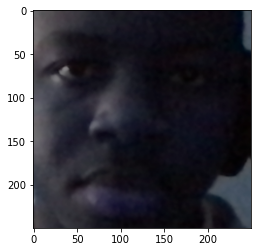

In [10]:
#Place the webcam approximately 0.9 metres from the student while
# taking the images
plt.imshow(frame)

# Load & Preprocess Images

## 3.1 Get Image Directories

In [11]:
#Grab only 300 images within a specific directory
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2022-07-06 11:50:23.246789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
ANC_PATH+'/*jpg/'

'data/anchor/*jpg/'

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
print(dir_test.next())

b'data/anchor/7b2d7bfc-e637-11ec-8a2d-acde48001122.jpg'


## 3.2 Preprocessing - Scale & Resize

In [15]:
#load image, resize, and scale it

In [16]:
#preprocess function
def preprocess (file_path):
    # Read in image from file path (in byte form)
    byte_img = tf.io.read_file(file_path)
    #load in image
    img = tf.io.decode_jpeg(byte_img, channels=3)
    
    # Preprocessing steps - resizing the image to 100px X 100px X 3 channels
    # Why 100 X 100? (it's based on the Siames model doc)
    img = tf.image.resize(img, (100,100))
    #Scale image to be btw 0 and 1
    img = img/255.0
    #return img
    return img

In [17]:
img = preprocess('data/negative/Clare_Short_0001.jpg')

In [18]:
img.numpy().max()

0.99852943

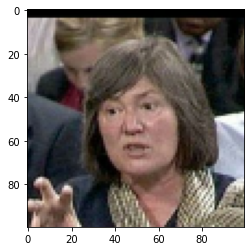

In [19]:
#display image after scaling
plt.imshow(img)

In [20]:
!pip3 install tensorflow_datasets

In [21]:
!pip install torch

In [22]:
anchor.map(preprocess)

<MapDataset element_spec=TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None)>

## 3.3 Create a labelled Dataset

In [23]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
samples = data.as_numpy_iterator()

In [26]:
example = samples.next()

In [27]:
example

(b'data/anchor/81df37f6-e637-11ec-8a2d-acde48001122.jpg',
 b'data/positive/c0b39e54-e637-11ec-8a2d-acde48001122.jpg',
 1.0)

## 3.4 Build Train & Test Partition

In [28]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [29]:
res = preprocess_twin(*example)

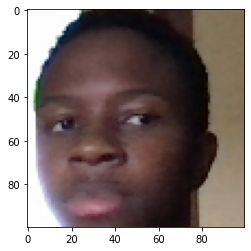

In [30]:
plt.imshow(res[0])

In [31]:
res[2]

1.0

In [32]:
#build a dataloader pipeline

#map
data = data.map(preprocess_twin)
#cache images
data = data.cache()
#shuffle images for approprite training
data = data.shuffle(buffer_size=1024)

In [33]:
sampless = data.as_numpy_iterator()

In [34]:
len(sampless.next())

3

In [35]:
samp = sampless.next()

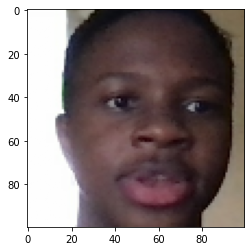

In [36]:
plt.imshow(samp[1])

In [37]:
samp[2]

1.0

In [38]:
#Training partition

#take 70% of the dataset for training and round it
train_data = data.take(round(len(data)*.7))
#pass the data in batches of 16 units
train_data = train_data.batch(16)
#prefetch preprocesses the next data in order to reduce bottleneck in the model
train_data = train_data.prefetch(8)

In [39]:
train_samples = train_data.as_numpy_iterator()

In [40]:
train_sample = train_samples.next()

In [41]:
len(train_sample[0])

16

In [42]:
#Testing partition

test_data = data.skip(round(len(data)*.7))

#grab the remaining 30% for testing purposes
test_data = test_data.take(round(len(data)*.3))

test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [43]:
def make_embedding():
    #defining the input layer (with reference to the Siamese paper)
    inp = Input(shape=(100,100,3), name='input_image')
    
    #FIRST BLOCK
    #convolution layer plus Relu activation (64 units/filters/channels)
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    #max pooling layer
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #SECOND BLOCK
    #(128 units with relu activation)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #THIRD BLOCK
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #FINAL EMBEDDING BLOCK
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    #flatten to a single dimension
    f1 = Flatten()(c4)
    
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [44]:
embedding = make_embedding()

In [45]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [46]:
#Create a Siamese class L1Dist for the neural network layer
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        #inheritance
        super().__init__()
    
    #checking the similarity btw respective anchor image 
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [47]:
l1 = L1Dist()

In [ ]:
l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [48]:
def make_siamese_model():
    
    #Handle inputs
    
    #Anchor image in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    #Combine siamese deistance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiamesNetwork')
    

In [49]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiamesNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][0

# Training

## 5.1 Setup Loss and Optimizer

In [51]:
#Loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
#Using the Adam optimizer

#1e-4 is the learning rate of #0.001
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [53]:
#directory to save all our dir checkpoints
checkpoint_dir = './training_checkpoints'
#ckpt prefix for all checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [54]:
test_batch = train_data.as_numpy_iterator()

In [55]:
batch_1 = test_batch.next()

In [56]:
X = batch_1[:2]

In [57]:
y = batch_1[2]

In [58]:
y

array([1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [59]:
tf.losses.BinaryCrossentropy??

In [60]:
#Training on one batch of data

#Why use a tf.function manner?
# It compiles a function into a callable TensorFlow graph
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss
    

## 5.4 Build Training Loop

In [61]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [62]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [63]:
EPOCHS = 50

In [64]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
26/26 [==============================] - 149s 6s/step
0.21168008 0.6039604 0.9918699

 Epoch 2/50
26/26 [==============================] - 144s 6s/step
0.0768189 0.9466019 0.9898477

 Epoch 3/50
26/26 [==============================] - 146s 6s/step
0.07775368 0.969697 0.9948186

 Epoch 4/50
26/26 [==============================] - 150s 6s/step
0.07467936 0.95477384 0.98445594

 Epoch 5/50
26/26 [==============================] - 145s 6s/step
0.0077387444 0.9444444 0.9946808

 Epoch 6/50
1/1 [==============================] - 1s 737ms/step


26/26 [==============================] - 115s 4s/step
0.060747642 0.9947644 1.0

 Epoch 7/50
26/26 [==============================] - 121s 5s/step
0.03732034 0.97969544 0.9948454

 Epoch 8/50
26/26 [==============================] - 118s 5s/step
0.022507317 1.0 1.0

 Epoch 9/50
26/26 [==============================] - 117s 5s/step
0.039249368 1.0 1.0

 Epoch 10/50
26/26 [==============================] - 120s 5s/step
0.01211984 1.0 1.0

 Epoch 11/50
26/26 [==============================] - 129s 5s/step


0.0030994697 1.0 1.0

 Epoch 12/50
26/26 [==============================] - 126s 5s/step
0.00019898443 1.0 1.0

 Epoch 13/50
26/26 [==============================] - 121s 5s/step
0.0005760176 1.0 1.0

 Epoch 14/50
26/26 [==============================] - 126s 5s/step
0.00074065884 1.0 1.0

 Epoch 15/50
26/26 [==============================] - 137s 5s/step
0.0005599755 1.0 1.0

 Epoch 16/50
26/26 [==============================] - 144s 6s/step
0.0013996873 1.0 1.0

 Epoch 17/50
1/1 [==============================] - 1s 967ms/step


26/26 [==============================] - 146s 6s/step
0.0005642379 1.0 1.0

 Epoch 18/50
26/26 [==============================] - 144s 6s/step
0.0007513791 1.0 1.0

 Epoch 19/50
26/26 [==============================] - 146s 6s/step
0.000110609006 1.0 1.0

 Epoch 20/50
26/26 [==============================] - 144s 6s/step
0.00158809 1.0 1.0

 Epoch 21/50
26/26 [==============================] - 143s 6s/step
0.00033136358 1.0 1.0

 Epoch 22/50
26/26 [==============================] - 143s 6s/step
0.00049175334 1.0 1.0

 Epoch 23/50
1/1 [==============================] - 1s 967ms/step


26/26 [==============================] - 144s 6s/step
0.00063755363 1.0 1.0

 Epoch 24/50
26/26 [==============================] - 143s 6s/step
1.0132841e-06 1.0 1.0

 Epoch 25/50
26/26 [==============================] - 144s 6s/step
0.0008807367 1.0 1.0

 Epoch 26/50
26/26 [==============================] - 148s 6s/step
8.220737e-05 1.0 1.0

 Epoch 27/50
26/26 [==============================] - 115s 4s/step
0.00064929866 1.0 1.0

 Epoch 28/50
1/1 [==============================] - 1s 742ms/step


26/26 [==============================] - 113s 4s/step
0.0010995975 1.0 1.0

 Epoch 29/50
26/26 [==============================] - 116s 4s/step
0.00026451162 1.0 1.0

 Epoch 30/50
26/26 [==============================] - 115s 4s/step
0.0004512933 1.0 1.0

 Epoch 31/50
26/26 [==============================] - 115s 4s/step
0.00026166276 1.0 1.0

 Epoch 32/50
26/26 [==============================] - 115s 4s/step
4.165408e-05 1.0 1.0

 Epoch 33/50
26/26 [==============================] - 116s 4s/step
0.0001667705 1.0 1.0

 Epoch 34/50
1/1 [==============================] - 1s 765ms/step


26/26 [==============================] - 117s 4s/step
1.5170454e-05 1.0 1.0

 Epoch 35/50
26/26 [==============================] - 118s 5s/step
2.899979e-05 1.0 1.0

 Epoch 36/50
26/26 [==============================] - 117s 4s/step
0.0002434178 1.0 1.0

 Epoch 37/50
26/26 [==============================] - 121s 5s/step
6.0645416e-05 1.0 1.0

 Epoch 38/50
26/26 [==============================] - 119s 5s/step
3.0229185e-05 1.0 1.0

 Epoch 39/50
1/1 [==============================] - 1s 1s/step


26/26 [==============================] - 124s 5s/step
0.00036504326 1.0 1.0

 Epoch 40/50
26/26 [==============================] - 121s 5s/step
7.875639e-05 1.0 1.0

 Epoch 41/50
26/26 [==============================] - 120s 5s/step
0.00027739952 1.0 1.0

 Epoch 42/50
26/26 [==============================] - 126s 5s/step
6.8354384e-05 1.0 1.0

 Epoch 43/50
26/26 [==============================] - 129s 5s/step
0.00019712231 1.0 1.0

 Epoch 44/50
26/26 [==============================] - 131s 5s/step
9.7576685e-06 1.0 1.0

 Epoch 45/50
1/1 [==============================] - 1s 840ms/step


26/26 [==============================] - 130s 5s/step
3.1601234e-05 1.0 1.0

 Epoch 46/50
26/26 [==============================] - 125s 5s/step
5.147801e-05 1.0 1.0

 Epoch 47/50
26/26 [==============================] - 131s 5s/step
2.4827674e-05 1.0 1.0

 Epoch 48/50
26/26 [==============================] - 126s 5s/step
0.0001451413 1.0 1.0

 Epoch 49/50
26/26 [==============================] - 127s 5s/step
8.797877e-06 1.0 1.0

 Epoch 50/50
26/26 [==============================] - 132s 5s/step
2.9299734e-05 1.0 1.0


## Evaluate Model

## 6.1 Import Metrics

In [73]:
# Import metric calculation
from tensorflow.keras.metrics import Precision, Recall

In [74]:
# Get test data

#convert tensorflow dataset into a numpy iterator
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

## 6.2 Make Predictions

In [75]:
# Making predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[1.8690688e-08],
       [4.1195665e-09],
       [2.5123970e-09],
       [9.9995482e-01],
       [1.9710579e-10],
       [1.7667279e-09],
       [1.0000000e+00],
       [1.7138091e-09],
       [9.9999523e-01],
       [1.7381609e-08],
       [2.4356348e-07],
       [9.9998111e-01],
       [9.9936241e-01],
       [9.9998558e-01],
       [9.7768137e-08],
       [1.0000000e+00]], dtype=float32)

In [87]:
# Post processing the results
[1 if prediction > 0.7 else 0 for prediction in y_hat]

[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]

In [88]:
y_true

array([0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

## 6.3 Calculation Metrics

In [90]:
#Creating a metric object
m = Recall()
#Calculate the recall value
m.update_state(y_true, y_hat)

# Return Recall() result
m.result().numpy()

1.0

In [91]:
#Creating a metric object
m = Precision()
#Calculate the precision value
m.update_state(y_true, y_hat)

# Return Precision() result
m.result().numpy()

1.0

## 6.4 Lee's Results

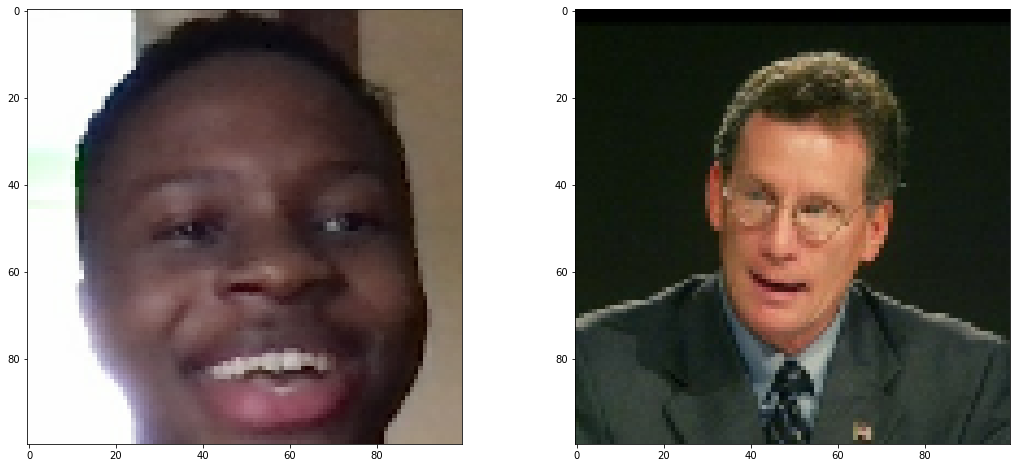

In [96]:
#Compare the results with the arrays in section 2.2

#setting image/plot size
plt.figure(figsize=(18,8))
#Setting first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])

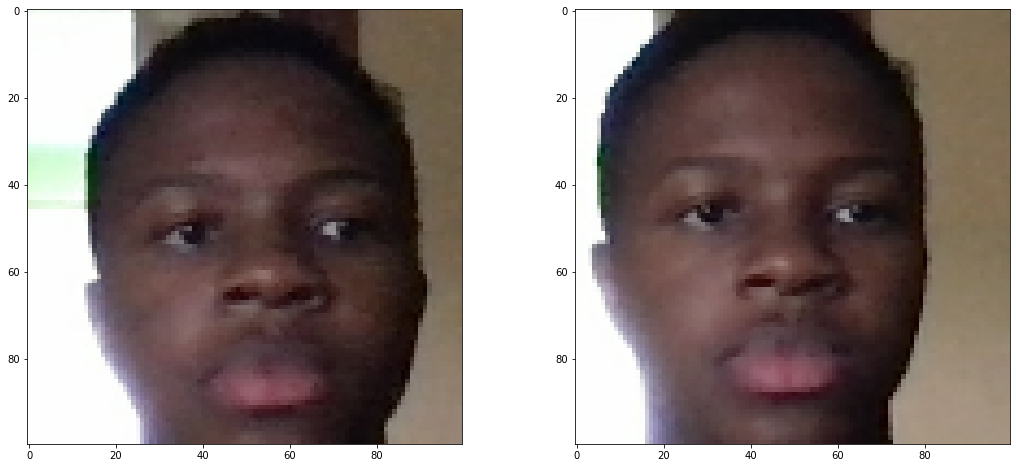

In [95]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[3])
plt.subplot(1,2,2)
plt.imshow(test_val[3])

## 7. Save Model

## 8. Real Time Test

## 8.1 Verification Function

## 8.2 OpenCV Real Time Verification